# Deforestation Detection using GeoTIFF Images from Google Earth
This project offers a glimpse into satellite image processing, specifically using GeoTIFF images from Google Earth to detect deforestation. Here's the workflow:

* Reading GeoTiff images using Gdal.
* Extracting and using different bands from GeoTiff images.
* Calculating Normalized Difference Vegetation Index (NDVI) using the GeoTiff Images.
* Using NDVI to analyse deforestation.

The TIFF images are obtained using the Google Earth Engine.

## TIFF vs GeoTIFF

Understand the difference: TIFF files store raster graphics, while GeoTIFF includes georeferencing metadata.

In [32]:
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline
import glob
plt.rcParams['image.cmap'] = 'gray'
from osgeo import gdal

# Geospatial Data Abstraction Library (GDAL)
Utilize GDAL to work with raster and vector geospatial data formats, including opening GeoTIFF files and extracting raster bands for analysis.

In [33]:
# Open a GeoTIFF image file
ds = gdal.Open('deforestation/2001api.tif')

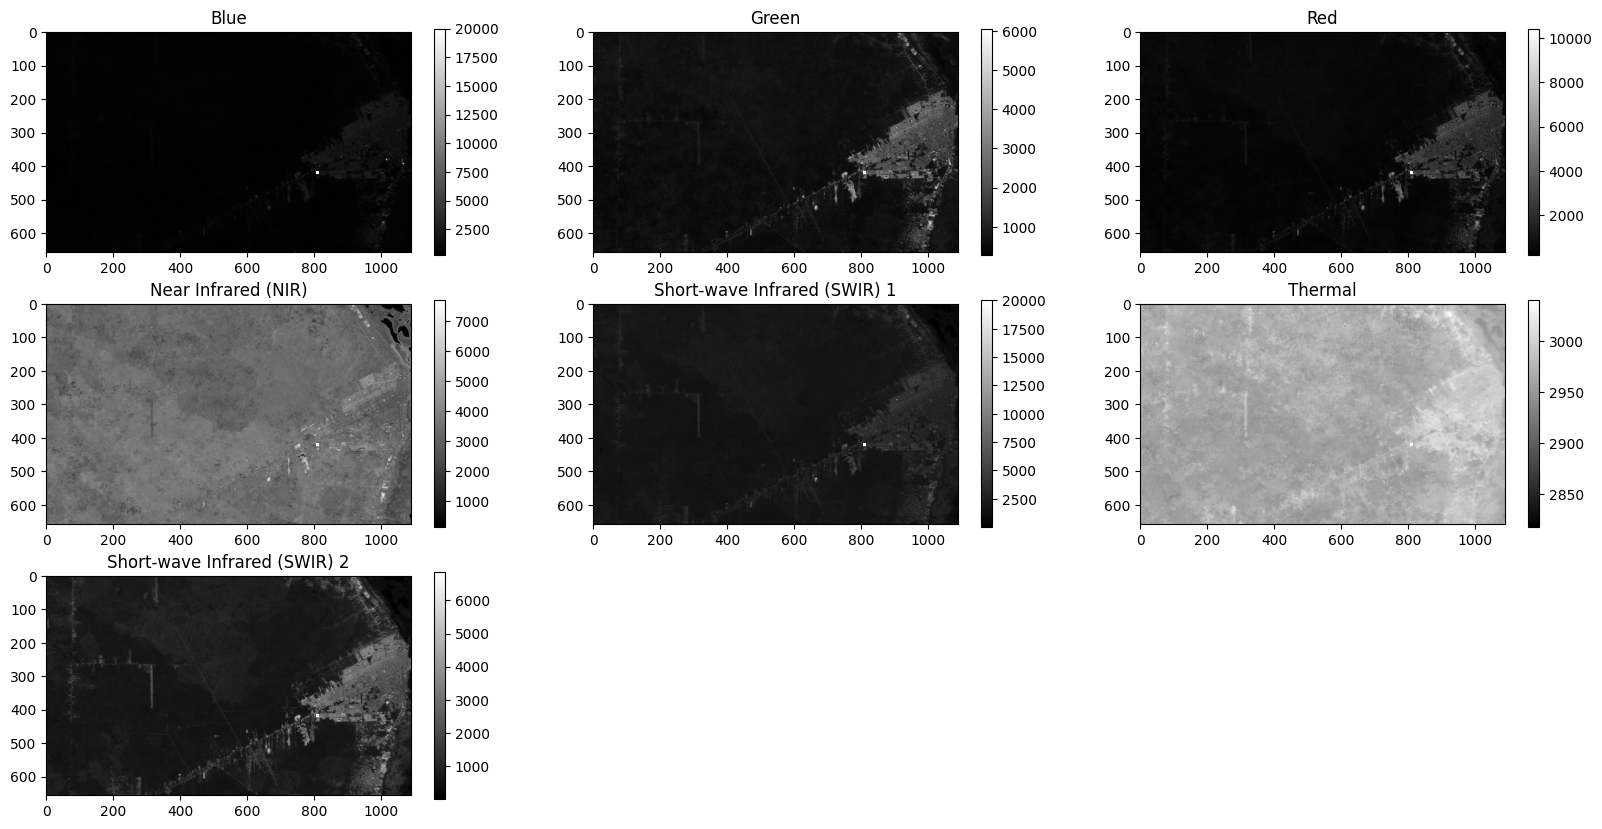

In [34]:
# Extract the various bands from the GeoTIFF image
plt.figure(figsize = (20,10))
plt.subplot(331); plt.imshow(ds.GetRasterBand(1).ReadAsArray()); plt.title("Blue"); plt.colorbar();
plt.subplot(332); plt.imshow(ds.GetRasterBand(2).ReadAsArray()); plt.title("Green"); plt.colorbar();
plt.subplot(333); plt.imshow(ds.GetRasterBand(3).ReadAsArray()); plt.title("Red"); plt.colorbar();
plt.subplot(334); plt.imshow(ds.GetRasterBand(4).ReadAsArray()); plt.title("Near Infrared (NIR)"); plt.colorbar();
plt.subplot(335); plt.imshow(ds.GetRasterBand(5).ReadAsArray()); plt.title("Short-wave Infrared (SWIR) 1"); plt.colorbar();
plt.subplot(336); plt.imshow(ds.GetRasterBand(6).ReadAsArray()); plt.title("Thermal"); plt.colorbar();
plt.subplot(337); plt.imshow(ds.GetRasterBand(7).ReadAsArray()); plt.title("Short-wave Infrared (SWIR) 2"); plt.colorbar();

# Normalized Difference Vegetation Index (NDVI)
**Normalized difference vegetation index** or NDVI is a key metric for assessing vegetation density **(can be used to estimate the density of green on an area of land)**. <br>
The NDVI is calculated as: <br>
``` math
 NDVI = (NIR - RED) / (NIR  + RED)
 ```
 where `Red` and `NIR` stand for the spectral reflectance measurements acquired in the red (visible) and near-infrared regions, respectively. The NDVI score for an area with vegetation should lie between 0.3 ( light vegetation ) to 0.8 ( heavy vegetation ). Clouds will have a negative index, while soil and bodies of water will have low positive values. We will use this information to estimate the vegetation of a certain region.

## Near Infra Red Region (NIR)

**NIR** has a wavelength of 0.76 - 0.90 µm. Plant life absorbs visible light from 0.4 µm (blue light) and up to 0.7 µm (red light) for photosynthesis, with peak absorption towards both ends of this spectrum. We see plants as green because they typically don't absorb the green wavelengths of light (~0.5 µm) in the middle of this range. However, this does make the green channel less accurate for detection of vegetation because it falls within the full range of wavelengths used for photosynthesis. On the other hand, plants strongly reflects near-infrared light (from 0.7 to 1.1 µm). This fact is exploited in calculating NDVI.

The NDVI is calculated from the Red and NIR Bands. In LandSat5, these are the 3rd and 4th bands. So, we will use GDAL to get those bands and calculate NDVI.

In [35]:
# Calculate the NDVI from Landsat5 images
def get_NDVI(ds):
    r = ds.GetRasterBand(3).ReadAsArray()
    nir = ds.GetRasterBand(4).ReadAsArray()
    ndvi = (nir - r)/(nir + r)
    ndvi = normalize255(ndvi)
    return ndvi

# Normalize NDVI Values

In [36]:
# Normalize ndvi from (-1, 1) to (0, 255)
def normalize255(ndvi):
    ndvi = ndvi + 1
    ndvi = (ndvi / 2) * 255
    return ndvi

# Segment Forested Areas Using Threshold-Based Approach

In [37]:
# Get Segmented mask of NDVI
# Use 200 (midway between 0.3 (light vegetation) and 0.8 (heavy vegetation)) as the threshold to estimate forest area
def get_NDVI_mask(ndvi):
    _, mask = cv2.threshold(ndvi, 200, 255, cv2.THRESH_BINARY)
    return mask

In [38]:
# Calculate the percentage of forestation using the generated mask
def percent_forest(mask):
    c = cv2.countNonZero(mask)
    t = mask.shape[0] * mask.shape[1]
    return round((c / t) * 100, 4)

# Visualizing NDVI and Forestation </font>
Calculate the percentage of forestation and visualize NDVI and segmented masks for better interpretation.

In [39]:
def plot_NDVI(path):
    ds = gdal.Open(path)
    ndvi = get_NDVI(ds)
    ndvi_mask = get_NDVI_mask(ndvi)

    year = path.split('.')[0][:4]
    fig = plt.figure(figsize = (20, 5))
    fig = plt.subplot(1, 2, 1)
    plot = plt.imshow(ndvi, cmap = "gray")
    plt.colorbar()
    plt.title(year + ": " + "NDVI") 
    plt.xticks([]), plt.yticks([])
    fig = plt.subplot(1, 2, 2)
    plot = plt.imshow(ndvi_mask, cmap = "gray"); 
    plt.title(str(percent_forest(ndvi_mask)) + "%") 
    plt.xticks([]), plt.yticks([])
    plt.show()

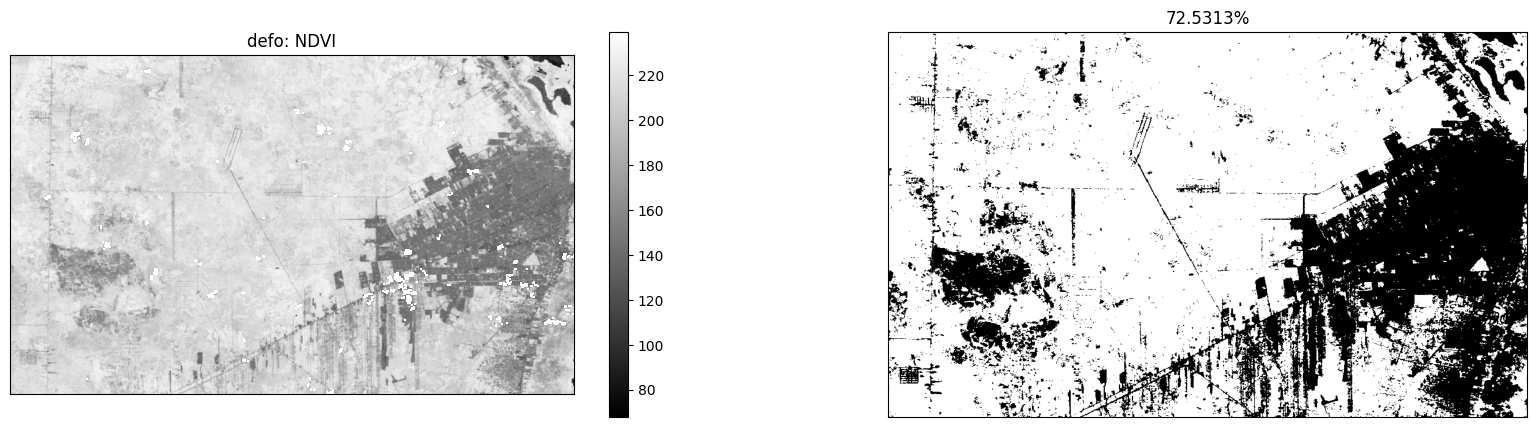

In [40]:
plot_NDVI('deforestation/2011api.tif')

## Plotting All Years of Data

The White portion in the Mask demonstrates the Forested sections of the area based on NDVI.

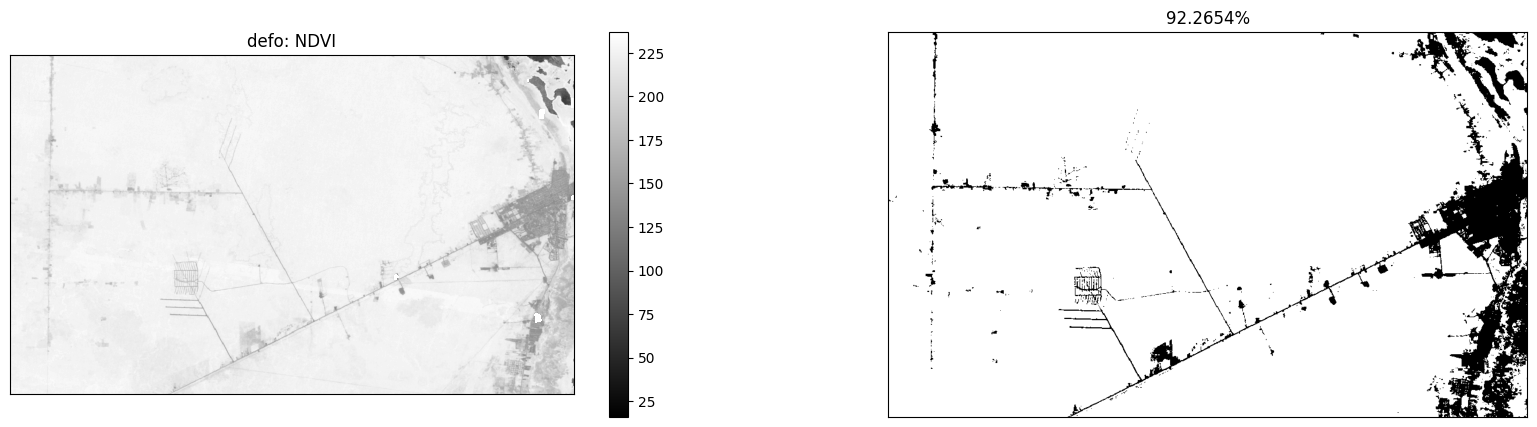

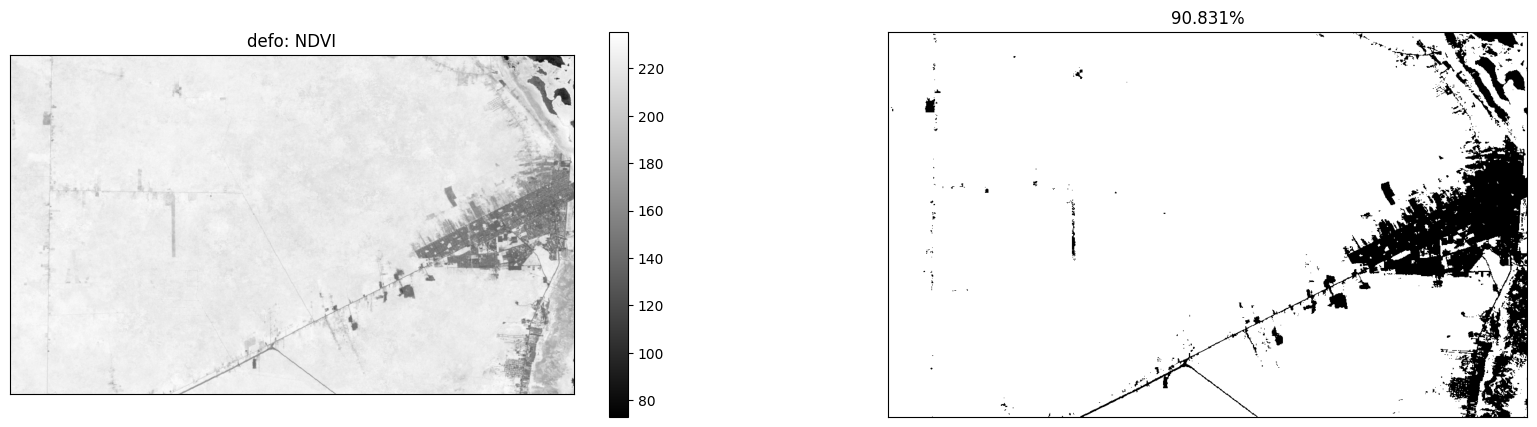

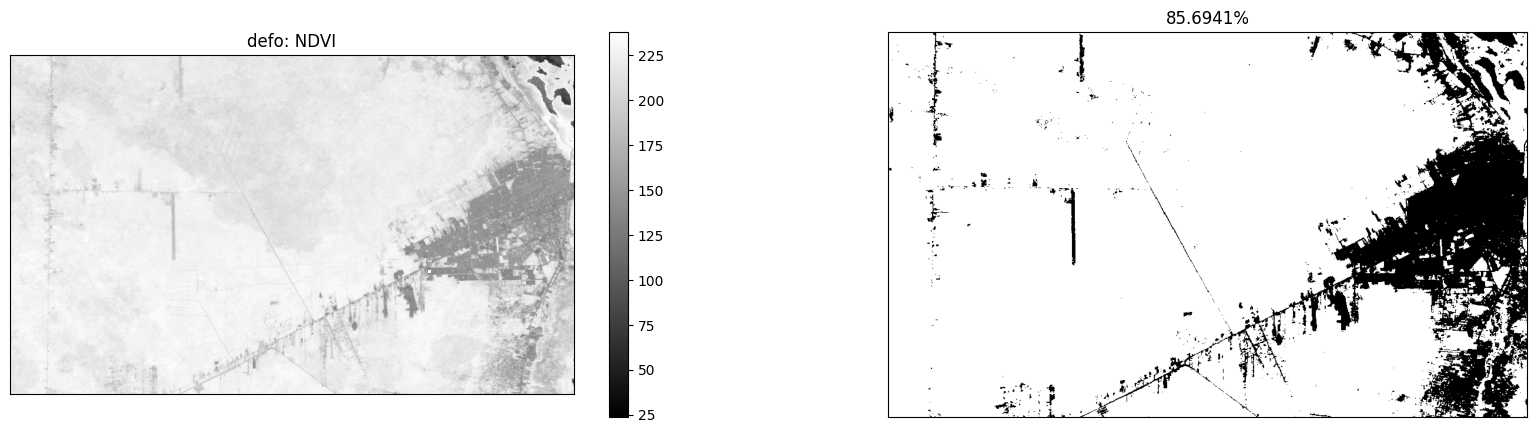

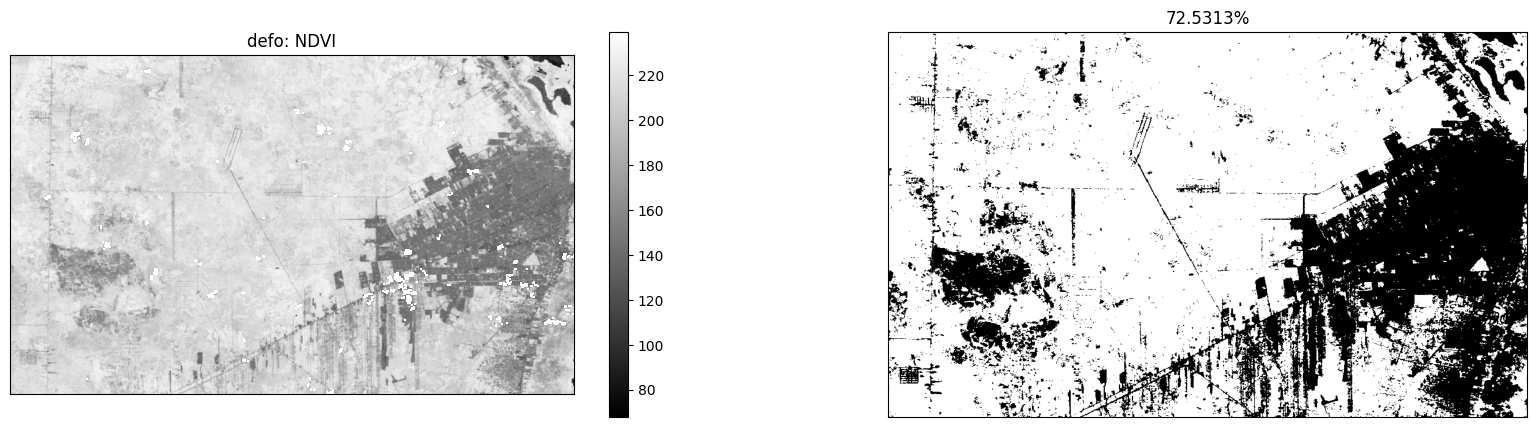

In [41]:
geotiff_files = glob.glob("deforestation/*.tif")
geotiff_files.sort()
for file in geotiff_files:
    plot_NDVI(file)

# Conclusion
Satellite image analysis opens doors to a wide array of applications, including environmental monitoring and land cover analysis. This project provides a glimpse into the potential of satellite imagery and encourages further exploration in this fascinating field.